In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# Functions

In [10]:
# Ill need a function that takes in a gene name and site and generates the linear motif for that site.
# I'll use the central position format.

# First need to create a sequence library to reference quickly
fasta_file_path = "C:/Users/Regan/Box/CellBio-MajorLab/Users/Isaac/Datasets/Human_sp_20230119_3AUP00000564.fasta"
#fasta_file_path = "/Users/reganwilliamson/Library/CloudStorage/Box-Box/CellBio-MajorLab/Users/Isaac/Datasets/Human_sp_20230119_3AUP00000564.fasta"
sequence_lib = {}

duplicate_counter = 0

current_gene_name = ""
current_sequence = ""
with open(fasta_file_path, 'r') as fasta_file:
    for line in fasta_file:
        line = line.strip()
        if line.startswith('>'):  # New gene sequence starts
            if current_gene_name and current_sequence:
                sequence_lib[current_gene_name] = current_sequence
            current_gene_name = line.split("|")[1]  # Remove ">" from gene name
            current_sequence = ""
        else:
            current_sequence += line
    # Add the last gene sequence after the loop ends
    if current_gene_name and current_sequence:
        sequence_lib[current_gene_name] = current_sequence

# Next need a way to map gene names to uniprot IDs. This is not optimal but for some reason the CPTAC data is indexed by gene name.
mapping_path = "C:/Users/Regan/Box/CellBio-MajorLab/Users/Isaac/Datasets/uniprot_mapping.txt"
# mapping_path = "/Users/reganwilliamson/Library/CloudStorage/Box-Box/CellBio-MajorLab/Users/Isaac/Datasets/uniprot_mapping.txt"
mapping_df = pd.read_csv(mapping_path,sep='\t')
mapping_df_cleaned = mapping_df.dropna(subset=["GeneID"])
mapping = dict(zip(mapping_df["Gene_Name"], mapping_df["UniProt"]))

def get_motif(gene,position):
    motif = ""
    
    try:
        index = int(position[1:])
    except:
        #print("Weird site position, Skipping...   " + position)
        return np.nan

    try:
        uniprot = mapping[gene]
    except:
        #print("Couldn't map " + gene)
        return np.nan

    try:
        sequence = sequence_lib[uniprot]
    except:
        #print("Couldn't find sequence for uniprot ID:  " + uniprot)
        return np.nan

    # Make sure the input phosphosite matches the amino acid at the indexed position
    if index>len(sequence):
        #print("Index not in range of sequence length: " + str(index) + '\t' + str(len(sequence)))
        return np.nan
    
    if sequence[index-1] != position[0]:
        #print("Site residue did not match indexed residue: " + gene + '\t' + position)
        #print(sequence[index-1])
        #print(position[0])
        return np.nan
    
    # Need 7 residues before and after
    if len(sequence) < 15:
        #print("Bad sequence: " + uniprot)
        #print("\t" + sequence)
        return np.nan #Bad sequence
    
    # Sequence start edge case
    if index < 8:
        motif = (8-index)*"_"
        motif = motif + sequence[:index+7]
        return motif
        
    if len(sequence)-index < 8:
        motif = sequence[index-8:]
        motif = motif + (7-(len(sequence)-index))*"_"
        return motif
        
    motif = sequence[index-8:index+7] 
    return motif

In [11]:
# Code for mixing correction:
def correct_mixing(dataset,columns):
    data = dataset[columns]
    sums = np.sum(data)
    corrected = data/(sums/np.mean(sums))
    return corrected

In [12]:
# Code for protein-level normalization
def protein_normalize(dataset,columns,protein_data,protein_columns):
    return dataset


# Analyze the data


In [14]:
#phosphosites_file = "/Users/reganwilliamson/Library/CloudStorage/Box-Box/CellBio-MajorLab/Users/Regan/TMT_Search/txt_phospho/Phospho (STY)Sites.txt"
phosphosites_file = "/Users/Regan/Box/CellBio-MajorLab/Users/Regan/TMT_Search/txt_phospho/Phospho (STY)Sites.txt"
phospho_data = pd.read_csv(phosphosites_file,sep='\t')
phospho_data

C:\Users\Regan\AppData\Local\Temp\ipykernel_12708\1740586518.py:3: DtypeWarning: Columns (18,206,207) have mixed types. Specify dtype option on import or set low_memory=False.
  phospho_data = pd.read_csv(phosphosites_file,sep='\t')


,Proteins,Positions within proteins,Leading proteins,Protein,Protein names,Gene names,Fasta headers,Localization prob,FLR,Score diff,...,Best localization raw file,Best localization scan number,Best score evidence ID,Best score MS/MS ID,Best score raw file,Best score scan number,Best PEP evidence ID,Best PEP MS/MS ID,Best PEP raw file,Best PEP scan number
0,A0A087WZS1;A0A087WU71;A0A087WWR4;A0A024R0Y4,6;6;6;6,A0A087WZS1,A0A087WZS1,Transcriptional adapter,TADA2A,tr|A0A087WZS1|A0A087WZS1_HUMAN Transcriptional...,0.566409,0.105611,1.81988,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,6349,9096,10325,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,6349,9096,10325,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,6349
1,Q3KR37;A0A024R3M2;A0A2R8Y5X2;A0A1B0GWG7;A0A1B0...,550;510;514;579;693,Q3KR37,Q3KR37,Protein Aster-B,GRAMD1B,sp|Q3KR37|ASTRB_HUMAN Protein Aster-B OS=Homo ...,0.995113,0.000578,24.59090,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F8...,5874,19253,21944,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F8...,5874,19253,21944,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F8...,5874
2,Q00341;C9JT62;C9JIZ1;C9J5E5;C9JZI8;C9JES8;C9JH...,11;11;11;11;11;11;11;11;11;11;11;11;11;11;11;1...,Q00341,Q00341,Vigilin,HDLBP,sp|Q00341|VIGLN_HUMAN Vigilin OS=Homo sapiens ...,0.998625,0.000150,28.76010,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F4...,8355,18350,20936,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F4...,8355,18350,20936,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F4...,8355
3,Q00341;C9JT62;C9JIZ1;C9J5E5;C9JZI8;C9JES8;C9JH...,31;31;31;31;31;31;31;31;31;31;31;31;31;31,Q00341,Q00341,Vigilin,HDLBP,sp|Q00341|VIGLN_HUMAN Vigilin OS=Homo sapiens ...,0.928597,0.011890,11.51800,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,13520,20685,23582,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,13520,20685,23582,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,13520
4,Q7Z739;A0A024R7W5;A0A087X0Q1;A0A087WY31,385;334;383;388,Q7Z739,Q7Z739,YTH domain-containing family protein 3;YTH dom...,YTHDF3,sp|Q7Z739|YTHD3_HUMAN YTH domain-containing fa...,0.617634,0.091512,5.51934,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,13736,4876,5551,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,13736,4876,5551,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,13736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14686,Q9Y2U5,240,Q9Y2U5,Q9Y2U5,Mitogen-activated protein kinase kinase kinase 2,MAP3K2,sp|Q9Y2U5|M3K2_HUMAN Mitogen-activated protein...,0.716199,0.061446,4.04971,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,12348,1543,1814,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,12348,1543,1814,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,12348
14687,Q9Y2W2,236,Q9Y2W2,Q9Y2W2,WW domain-binding protein 11,WBP11,sp|Q9Y2W2|WBP11_HUMAN WW domain-binding protei...,0.695694,0.068071,3.59108,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F5...,3917,14330,16355,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F5...,3917,14330,16355,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F5...,3917
14688,Q9Y597,668,Q9Y597,Q9Y597,BTB/POZ domain-containing protein KCTD3,KCTD3,sp|Q9Y597|KCTD3_HUMAN BTB/POZ domain-containin...,0.499281,0.131407,0.00000,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,8630,14656,16731,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,8630,14656,16731,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,8630
14689,Q9Y5R8,133,Q9Y5R8,Q9Y5R8,Trafficking protein particle complex subunit 1,TRAPPC1,sp|Q9Y5R8|TPPC1_HUMAN Trafficking protein part...,0.703684,0.064823,4.63439,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,3955,17598,20088,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,3955,17598,20088,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,3955


In [15]:
# Filter the data
filtered_phospho = phospho_data[phospho_data['Localization prob'] >= 0.75]
filtered_phospho = filtered_phospho[filtered_phospho['Reverse'] != '+']
filtered_phospho = filtered_phospho[filtered_phospho['Potential contaminant'] != '+']
filtered_phospho

,Proteins,Positions within proteins,Leading proteins,Protein,Protein names,Gene names,Fasta headers,Localization prob,FLR,Score diff,...,Best localization raw file,Best localization scan number,Best score evidence ID,Best score MS/MS ID,Best score raw file,Best score scan number,Best PEP evidence ID,Best PEP MS/MS ID,Best PEP raw file,Best PEP scan number
1,Q3KR37;A0A024R3M2;A0A2R8Y5X2;A0A1B0GWG7;A0A1B0...,550;510;514;579;693,Q3KR37,Q3KR37,Protein Aster-B,GRAMD1B,sp|Q3KR37|ASTRB_HUMAN Protein Aster-B OS=Homo ...,0.995113,0.000578,24.59090,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F8...,5874,19253,21944,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F8...,5874,19253,21944,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F8...,5874
2,Q00341;C9JT62;C9JIZ1;C9J5E5;C9JZI8;C9JES8;C9JH...,11;11;11;11;11;11;11;11;11;11;11;11;11;11;11;1...,Q00341,Q00341,Vigilin,HDLBP,sp|Q00341|VIGLN_HUMAN Vigilin OS=Homo sapiens ...,0.998625,0.000150,28.76010,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F4...,8355,18350,20936,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F4...,8355,18350,20936,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F4...,8355
3,Q00341;C9JT62;C9JIZ1;C9J5E5;C9JZI8;C9JES8;C9JH...,31;31;31;31;31;31;31;31;31;31;31;31;31;31,Q00341,Q00341,Vigilin,HDLBP,sp|Q00341|VIGLN_HUMAN Vigilin OS=Homo sapiens ...,0.928597,0.011890,11.51800,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,13520,20685,23582,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,13520,20685,23582,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,13520
5,P25787;H3BT36;A0A7I2V2H3;A0A024RA52,7;7;7;7,P25787,P25787,Proteasome subunit alpha type-2;Proteasome sub...,PSMA2,sp|P25787|PSA2_HUMAN Proteasome subunit alpha ...,0.879259,0.021891,9.37830,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F2...,13499,6349,7260,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F2...,13499,6349,7260,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F2...,13499
8,P46379;A0A7I2V508;A0A0G2JK23;A0A024RCR6;A0A7P0...,113;113;113;113;113;113;113;113;113;113;113;11...,P46379,P46379,Large proline-rich protein BAG6,BAG6,sp|P46379|BAG6_HUMAN Large proline-rich protei...,0.994413,0.000675,23.53710,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,2676,1352,1586,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,2852,1352,1586,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F3...,2852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14670,Q96G74;H7BZQ3,175;48,Q96G74,Q96G74,OTU domain-containing protein 5;ubiquitinyl hy...,OTUD5,sp|Q96G74|OTUD5_HUMAN OTU domain-containing pr...,0.818569,0.035171,6.84503,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F5...,7599,12016,13687,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F5...,7599,12016,13687,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F5...,7599
14674,Q9H2X6;Q86Z02;H7BXX9;Q5SQL3;J3KP92,361;352;354;352;352,Q9H2X6,Q9H2X6,Homeodomain-interacting protein kinase 2;Homeo...,HIPK2;HIPK1,sp|Q9H2X6|HIPK2_HUMAN Homeodomain-interacting ...,0.997857,0.000243,26.98730,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,2704,2106,2462,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,2704,2106,2462,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,2704
14681,Q9NTZ6,433,Q9NTZ6,Q9NTZ6,RNA-binding protein 12,RBM12,sp|Q9NTZ6|RBM12_HUMAN RNA-binding protein 12 O...,0.985407,0.001980,16.74720,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,10364,17664,20160,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,10364,17664,20160,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,10364
14682,Q9NYF8;E9PK91;E9PQN2;E9PKI6;A0A1W2PQ43;E9PK09;...,284;284;282;284;284;284;282;25,Q9NYF8,Q9NYF8,Bcl-2-associated transcription factor 1,BCLAF1,sp|Q9NYF8|BCLF1_HUMAN Bcl-2-associated transcr...,0.805324,0.038647,6.83701,...,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,3234,15775,18021,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,3013,15775,18021,MA6215_IBP_RW_BRSK2-BCKDK-SCYL2_TMT_Phospho_F1...,3013


C:\Users\Regan\AppData\Local\Temp\ipykernel_12708\2640204547.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  summarized_df = summarized_df.drop(['Reporter intensity corrected 16 TMT_Phospho', 'Reporter intensity corrected 3 TMT_Phospho', 'Reporter intensity corrected 18 TMT_Phospho'], 'columns')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Reporter intensity corrected 1 TMT_Phospho___1', 'Reporter intensity corrected 1 TMT_Phospho___2', 'Reporter intensity corrected 1 TMT_Phospho___3', 'Reporter intensity corrected 2 TMT_Phospho___1', 'Reporter intensity corrected 2 TMT_Phospho___2', 'Reporter intensity corrected 2 TMT_Phospho___3', 'Reporter intensity corrected 3 TMT_Phospho___1', 'Reporter intensity corrected 3 TMT_Phospho___2', 'Reporter intensity corrected 3 TMT_Phospho___3', 'Reporter intensity corrected 4 TMT_Phospho___1', 'Reporter intensity corrected 4 TMT_Phospho___2', 'Reporter intensity corrected 4 TMT_Phospho___3', 'Reporter intensity corrected 5 TMT_Phospho___1', 'Reporter intensity corrected 5 TMT_Phospho___2', 'Reporter intensity corrected 5 TMT_Phospho___3', 'Reporter intensity corrected 6 TMT_Phospho___1', 'Reporter intensity corrected 6 TMT_Phospho___2', 'Reporter intensity corrected 6 TMT_Phospho___3', 'Reporter intensity corrected 7 TMT_Phospho___1', 'Reporter intensity corrected 7 TMT_Phospho___2',

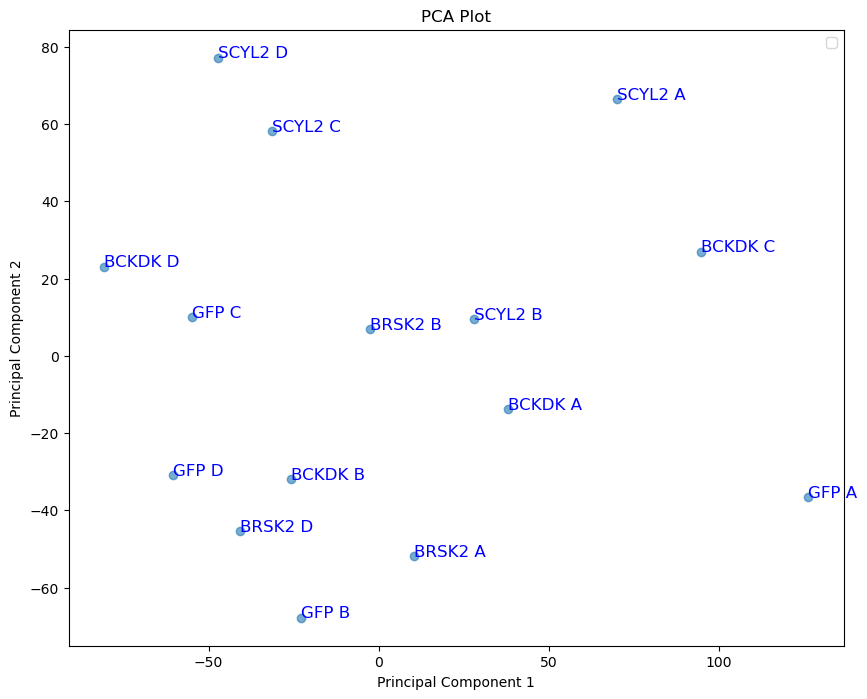

In [16]:
# Make a PCA plot
pca_cols_list = []
for col in filtered_phospho.columns:
    if 'Reporter intensity corrected' in col:
        pca_cols_list.append(col)

print(pca_cols_list)

pca_subset = filtered_phospho[pca_cols_list]

print(pca_subset)

column_names = [col.split('__')[0] for col in pca_subset.columns if '__' in col]

summarized_df = pd.DataFrame()

for column_name in set(column_names):
    # Filter columns with the current column name
    related_columns = [col for col in filtered_phospho.columns if col.startswith(column_name)]

    # Sum the related columns and store the result in the summarized DataFrame
    summarized_df[column_name] = filtered_phospho[related_columns].sum(axis=1)

summarized_df = summarized_df.drop(['Reporter intensity corrected 16 TMT_Phospho', 'Reporter intensity corrected 3 TMT_Phospho', 'Reporter intensity corrected 18 TMT_Phospho'], 'columns')

# Generate PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(summarized_df.T)

n_components = 4  # You can adjust the number of components based on your needs
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components + 1)])

columns_mapping = {
        'Reporter intensity corrected 1 TMT_Phospho':'GFP A',
       'Reporter intensity corrected 5 TMT_Phospho':'GFP B',
       'Reporter intensity corrected 7 TMT_Phospho':'GFP C',
       'Reporter intensity corrected 9 TMT_Phospho':'GFP D',
       'Reporter intensity corrected 2 TMT_Phospho':'BRSK2 A',
       'Reporter intensity corrected 4 TMT_Phospho':'BRSK2 B',
       'Reporter intensity corrected 6 TMT_Phospho':'BRSK2 D',
       'Reporter intensity corrected 11 TMT_Phospho':'BCKDK A',
       'Reporter intensity corrected 13 TMT_Phospho':'BCKDK B',
       'Reporter intensity corrected 15 TMT_Phospho':'BCKDK C',
       'Reporter intensity corrected 17 TMT_Phospho':'BCKDK D',
       'Reporter intensity corrected 8 TMT_Phospho':'SCYL2 A',
       'Reporter intensity corrected 10 TMT_Phospho':'SCYL2 B',
       'Reporter intensity corrected 12 TMT_Phospho':'SCYL2 C',
       'Reporter intensity corrected 14 TMT_Phospho':'SCYL2 D'
}

labels = []
for col in summarized_df.columns:
    labels.append(columns_mapping[col])

pca_df['label'] = labels

plt.figure(figsize=(10, 8))

plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.6)

# Annotate points with labels
for i, row in pca_df.iterrows():
    plt.annotate(row['label'], (row['PC1'], row['PC2']), fontsize=12, color='blue')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.legend()
plt.savefig("phospho_pcaPlot.png",dpi=1000)

In [17]:
explained_variance_ratios = pca.explained_variance_ratio_

# Print the explained variance ratios for each principal component
for i, explained_variance in enumerate(explained_variance_ratios):
    print(f"Explained Variance for PC{i+1}: {explained_variance:.4f}")

Explained Variance for PC1: 0.3850
Explained Variance for PC2: 0.2105
Explained Variance for PC3: 0.1334
Explained Variance for PC4: 0.0503


In [19]:
# Make a heatmap

# Make a PCA plot
pca_cols_list = []
for col in filtered_phospho.columns:
    if 'Reporter intensity corrected' in col:
        pca_cols_list.append(col)

pca_subset = filtered_phospho[pca_cols_list]

column_names = [col.split('__')[0] for col in pca_subset.columns if '__' in col]

heatmap_df = pd.DataFrame()

for column_name in set(column_names):
    # Filter columns with the current column name
    related_columns = [col for col in filtered_phospho.columns if col.startswith(column_name)]

    # Sum the related columns and store the result in the summarized DataFrame
    heatmap_df[column_name] = filtered_phospho[related_columns].sum(axis=1)
    
heatmap_df.rename(columns=columns_mapping, inplace=True)
heatmap_df = heatmap_df.drop(['Reporter intensity corrected 16 TMT_Phospho', 'Reporter intensity corrected 3 TMT_Phospho', 'Reporter intensity corrected 18 TMT_Phospho'], 'columns')
print(heatmap_df.columns)
# Now need to process this heatmap data by taking foldchange relative to the controls
fc_heatmap = pd.DataFrame()
for col in heatmap_df.columns:
    if 'GFP ' not in col:
        rep = col.split(' ')[1]
        ctrl_data = heatmap_df['GFP ' + rep]
        data = heatmap_df[col]
        FC = data/ctrl_data
        fc_heatmap[col] = FC
    else:
        print('skipped control')
        
#fc_heatmap.to_csv('/Users/reganwilliamson/Library/CloudStorage/Box-Box/CellBio-MajorLab/Users/Regan/TMT_Search/phospho_new/kinase_heatmap.csv')

Index(['BCKDK B', 'SCYL2 A', 'GFP B', 'GFP A', 'SCYL2 B', 'BCKDK A', 'BRSK2 B',
       'BCKDK C', 'GFP D', 'SCYL2 D', 'BCKDK D', 'BRSK2 D', 'SCYL2 C',
       'BRSK2 A', 'GFP C'],
      dtype='object')
skipped control
skipped control
skipped control
skipped control


C:\Users\Regan\AppData\Local\Temp\ipykernel_12708\185107289.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  heatmap_df = heatmap_df.drop(['Reporter intensity corrected 16 TMT_Phospho', 'Reporter intensity corrected 3 TMT_Phospho', 'Reporter intensity corrected 18 TMT_Phospho'], 'columns')


C:\Users\Regan\AppData\Local\Temp\ipykernel_6276\1870255782.py:1: RuntimeWarning: divide by zero encountered in log
  sns.clustermap(fc_heatmap.applymap(lambda x: np.log(x)).dropna().replace([np.inf, -np.inf], 0))
c:\Users\Regan\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


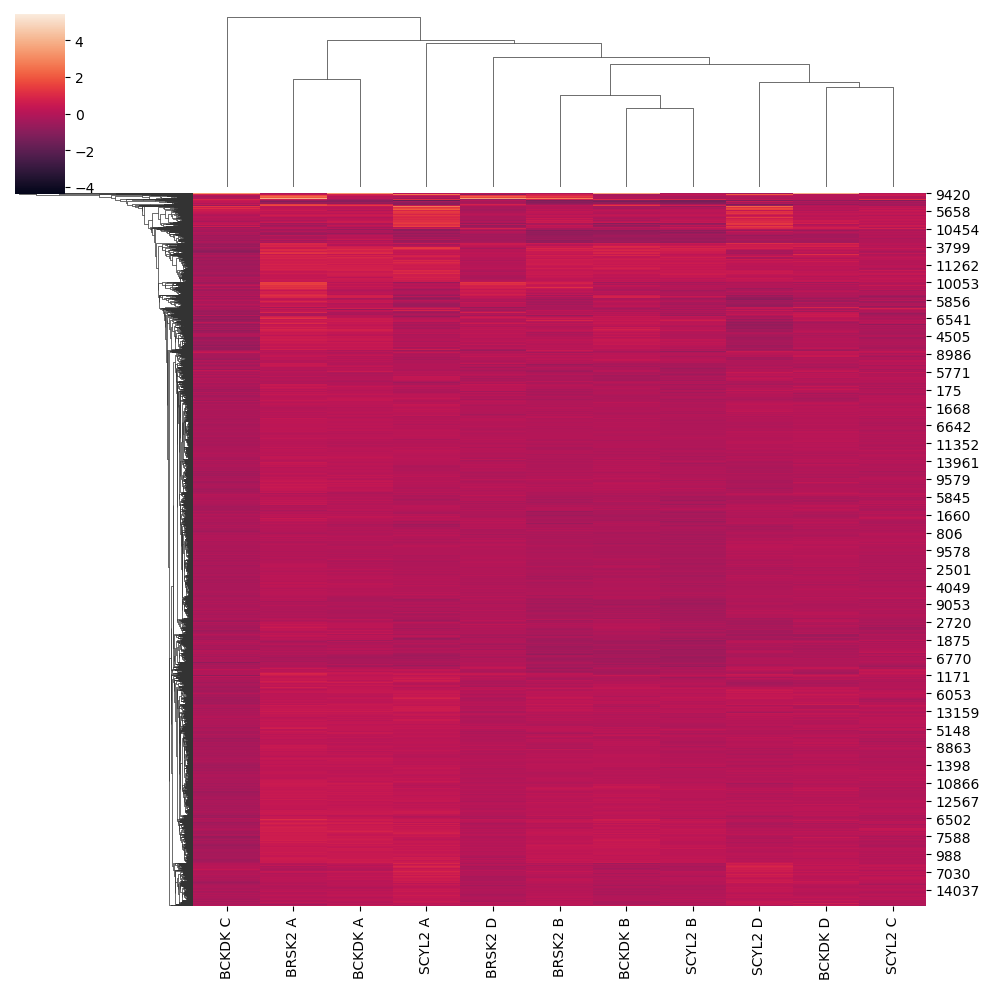

In [ ]:
sns.clustermap(fc_heatmap.applymap(lambda x: np.log(x)).dropna().replace([np.inf, -np.inf], 0))

In [ ]:
#this section
# Heatmap and PCA don't look great :/

# Now lets make some processed data tables
data = filtered_phospho

cols_list = []
non_quant_cols = []
for col in filtered_phospho.columns:
    if 'Reporter intensity corrected' in col:
        cols_list.append(col)
    elif 'Reporter intensity' in col:
        skip = True
    else:
        non_quant_cols.append(col)

quant_subset = filtered_phospho[cols_list]

non_quant_subset = filtered_phospho[non_quant_cols]

column_names = [col.split('__')[0] for col in quant_subset.columns if '__' in col]

quant_summarized = pd.DataFrame()

for column_name in set(column_names):
    # Filter columns with the current column name
    related_columns = [col for col in quant_subset.columns if col.startswith(column_name)]

    # Sum the related columns and store the result in the summarized DataFrame
    quant_summarized[column_name] = quant_subset[related_columns].sum(axis=1)
    
quant_summarized_mixCorrected = correct_mixing(quant_summarized,quant_summarized.columns)

columns_mapping = {
        'Reporter intensity corrected 1 TMT_Phospho':'GFP A',
       'Reporter intensity corrected 5 TMT_Phospho':'GFP B',
       'Reporter intensity corrected 7 TMT_Phospho':'GFP C',
       'Reporter intensity corrected 9 TMT_Phospho':'GFP D',
       'Reporter intensity corrected 2 TMT_Phospho':'BRSK2 A',
       'Reporter intensity corrected 4 TMT_Phospho':'BRSK2 B',
       'Reporter intensity corrected 6 TMT_Phospho':'BRSK2 D',
       'Reporter intensity corrected 11 TMT_Phospho':'BCKDK A',
       'Reporter intensity corrected 13 TMT_Phospho':'BCKDK B',
       'Reporter intensity corrected 15 TMT_Phospho':'BCKDK C',
       'Reporter intensity corrected 17 TMT_Phospho':'BCKDK D',
       'Reporter intensity corrected 8 TMT_Phospho':'SCYL2 A',
       'Reporter intensity corrected 10 TMT_Phospho':'SCYL2 B',
       'Reporter intensity corrected 12 TMT_Phospho':'SCYL2 C',
       'Reporter intensity corrected 14 TMT_Phospho':'SCYL2 D'
       }

quant_cols_order = [
    'GFP A',
    'GFP B',
    'GFP C',
    'GFP D',
    'BRSK2 A',
    'BRSK2 B',
    'BRSK2 D',
    'BCKDK A',
    'BCKDK B',
    'BCKDK C',
    'BCKDK D',
    'SCYL2 A',
    'SCYL2 B',
    'SCYL2 C',
    'SCYL2 D'
]

quant_summarized_mixCorrected.rename(columns=columns_mapping, inplace=True)

analysis_data = quant_summarized_mixCorrected[quant_cols_order]

# Now compute logFC and P-vals for all
comparisons = [
    'BCKDK',
    'SCYL2'
]

for kinase in comparisons:
    test_columns = [kinase + ' A', kinase + ' B', kinase + ' C', kinase + ' D']
    control_columns = ['GFP A', 'GFP B', 'GFP C', 'GFP D']
    
    #we have four instead of three
    log2_fold_changes = np.mean(np.log2([analysis_data[test_columns[0]]/analysis_data[control_columns[0]],
                                         analysis_data[test_columns[1]]/analysis_data[control_columns[1]],
                                         analysis_data[test_columns[2]]/analysis_data[control_columns[2]],
                                         analysis_data[test_columns[3]]/analysis_data[control_columns[3]]]),axis=0)
    
    
    #log2_fold_changes = np.log2(analysis_data[test_columns].mean(axis=1) / analysis_data[control_columns].mean(axis=1))
    t_test_p_values = [ttest_rel(control_data_row, test_data_row, alternative='less')[1] for control_data_row, test_data_row in zip(analysis_data[control_columns].values, analysis_data[test_columns].values)]
    #corrected_p_values = multipletests(t_test_p_values, method='fdr_bh')[1]

    
    analysis_data[kinase + '_log2FC'] = log2_fold_changes
    analysis_data[kinase + '_pval'] = t_test_p_values
    #analysis_data[kinase + '_FDR'] = corrected_p_values

#repeat for BRSK2
test_columns_BRSK2 = ['BRSK2 A', 'BRSK2 B', 'BRSK2 D']
control_columns = ['GFP A', 'GFP B', 'GFP D']

log2_fold_changes = np.mean(np.log2([analysis_data[test_columns_BRSK2[0]]/analysis_data[control_columns[0]],
                                     analysis_data[test_columns_BRSK2[1]]/analysis_data[control_columns[1]],
                                     analysis_data[test_columns_BRSK2[2]]/analysis_data[control_columns[2]]]),axis=0)

t_test_p_values = [ttest_rel(control_data_row, test_data_row, alternative='less')[1] for control_data_row, test_data_row in zip(analysis_data[control_columns].values, analysis_data[test_columns_BRSK2].values)]

analysis_data['BRSK2_log2FC'] = log2_fold_changes
analysis_data['BRSK2_pval'] = t_test_p_values

new_data = pd.concat([analysis_data,non_quant_subset],axis=1)

# Add the motif data
genes = list(new_data['Gene names'])
positions = list(new_data['Position'])
AAs = list(new_data['Amino acid'])
motifs = []
for i in range(len(genes)):
    gene = str(genes[i]).split(';')[0]
    position = AAs[i] + str(positions[i])
    motif = get_motif(gene,position)
    motifs.append(motif)
    
new_data['Motif'] = motifs

new_data.to_csv('/Users/reganwilliamson/Library/CloudStorage/Box-Box/CellBio-MajorLab/Users/Regan/TMT_Search/phospho_new/processed_kinases.csv',index=False)


/var/folders/n5/tzfjk_v17gbg8t367tcjk2d00000gn/T/ipykernel_99397/2601437570.py:85: RuntimeWarning: divide by zero encountered in log2
  log2_fold_changes = np.mean(np.log2([analysis_data[test_columns[0]]/analysis_data[control_columns[0]],
/var/folders/n5/tzfjk_v17gbg8t367tcjk2d00000gn/T/ipykernel_99397/2601437570.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data[kinase + '_log2FC'] = log2_fold_changes
/var/folders/n5/tzfjk_v17gbg8t367tcjk2d00000gn/T/ipykernel_99397/2601437570.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [ ]:
%debug

> /Users/reganwilliamson/opt/anaconda3/lib/python3.9/site-packages/pandas/io/common.py(786)get_handle()
    784         if ioargs.encoding and "b" not in ioargs.mode:
    785             # Encoding
--> 786             handle = open(
    787                 handle,
    788                 ioargs.mode,



In [ ]:
genes

0           E2F8
1          ESYT2
2          ESYT2
3          ESYT2
9          ESYT2
          ...   
14280       TJP2
14284      WBP11
14285    SUPT16H
14286      MMP24
14287      MMP24
Name: Gene names, Length: 9095, dtype: object

In [21]:
# Now lets make some processed data tables with two-tailed t-test
data = filtered_phospho

cols_list = []
non_quant_cols = []
for col in filtered_phospho.columns:
    if 'Reporter intensity corrected' in col:
        cols_list.append(col)
    elif 'Reporter intensity' in col:
        skip = True
    else:
        non_quant_cols.append(col)

quant_subset = filtered_phospho[cols_list]

non_quant_subset = filtered_phospho[non_quant_cols]

column_names = [col.split('__')[0] for col in quant_subset.columns if '__' in col]

quant_summarized = pd.DataFrame()

for column_name in set(column_names):
    # Filter columns with the current column name
    related_columns = [col for col in quant_subset.columns if col.startswith(column_name)]

    # Sum the related columns and store the result in the summarized DataFrame
    quant_summarized[column_name] = quant_subset[related_columns].sum(axis=1)
    
quant_summarized_mixCorrected = correct_mixing(quant_summarized,quant_summarized.columns)

columns_mapping = {
        'Reporter intensity corrected 1 TMT_Phospho':'GFP A',
       'Reporter intensity corrected 5 TMT_Phospho':'GFP B',
       'Reporter intensity corrected 7 TMT_Phospho':'GFP C',
       'Reporter intensity corrected 9 TMT_Phospho':'GFP D',
       'Reporter intensity corrected 2 TMT_Phospho':'BRSK2 A',
       'Reporter intensity corrected 4 TMT_Phospho':'BRSK2 B',
       'Reporter intensity corrected 6 TMT_Phospho':'BRSK2 D',
       'Reporter intensity corrected 11 TMT_Phospho':'BCKDK A',
       'Reporter intensity corrected 13 TMT_Phospho':'BCKDK B',
       'Reporter intensity corrected 15 TMT_Phospho':'BCKDK C',
       'Reporter intensity corrected 17 TMT_Phospho':'BCKDK D',
       'Reporter intensity corrected 8 TMT_Phospho':'SCYL2 A',
       'Reporter intensity corrected 10 TMT_Phospho':'SCYL2 B',
       'Reporter intensity corrected 12 TMT_Phospho':'SCYL2 C',
       'Reporter intensity corrected 14 TMT_Phospho':'SCYL2 D'
       }

quant_cols_order = [
    'GFP A',
    'GFP B',
    'GFP C',
    'GFP D',
    'BRSK2 A',
    'BRSK2 B',
    'BRSK2 D',
    'BCKDK A',
    'BCKDK B',
    'BCKDK C',
    'BCKDK D',
    'SCYL2 A',
    'SCYL2 B',
    'SCYL2 C',
    'SCYL2 D'
]

quant_summarized_mixCorrected.rename(columns=columns_mapping, inplace=True)

analysis_data = quant_summarized_mixCorrected[quant_cols_order]

# Now compute logFC and P-vals for all
comparisons = [
    'BCKDK',
    'SCYL2'
]

for kinase in comparisons:
    test_columns = [kinase + ' A', kinase + ' B', kinase + ' C', kinase + ' D']
    control_columns = ['GFP A', 'GFP B', 'GFP C', 'GFP D']
    
    #we have four instead of three
    log2_fold_changes = np.mean(np.log2([analysis_data[test_columns[0]]/analysis_data[control_columns[0]],
                                         analysis_data[test_columns[1]]/analysis_data[control_columns[1]],
                                         analysis_data[test_columns[2]]/analysis_data[control_columns[2]],
                                         analysis_data[test_columns[3]]/analysis_data[control_columns[3]]]),axis=0)
    
    
    #log2_fold_changes = np.log2(analysis_data[test_columns].mean(axis=1) / analysis_data[control_columns].mean(axis=1))
    t_test_p_values = [ttest_rel(control_data_row, test_data_row, alternative='two-sided')[1] for control_data_row, test_data_row in zip(analysis_data[control_columns].values, analysis_data[test_columns].values)]
    #corrected_p_values = multipletests(t_test_p_values, method='fdr_bh')[1]

    
    analysis_data[kinase + '_log2FC'] = log2_fold_changes
    analysis_data[kinase + '_pval'] = t_test_p_values
    #analysis_data[kinase + '_FDR'] = corrected_p_values

#repeat for BRSK2
test_columns_BRSK2 = ['BRSK2 A', 'BRSK2 B', 'BRSK2 D']
control_columns = ['GFP A', 'GFP B', 'GFP D']

log2_fold_changes = np.mean(np.log2([analysis_data[test_columns_BRSK2[0]]/analysis_data[control_columns[0]],
                                     analysis_data[test_columns_BRSK2[1]]/analysis_data[control_columns[1]],
                                     analysis_data[test_columns_BRSK2[2]]/analysis_data[control_columns[2]]]),axis=0)

t_test_p_values = [ttest_rel(control_data_row, test_data_row, alternative='two-sided')[1] for control_data_row, test_data_row in zip(analysis_data[control_columns].values, analysis_data[test_columns_BRSK2].values)]

analysis_data['BRSK2_log2FC'] = log2_fold_changes
analysis_data['BRSK2_pval'] = t_test_p_values

new_data = pd.concat([analysis_data,non_quant_subset],axis=1)

# Add the motif data
genes = list(new_data['Gene names'])
positions = list(new_data['Position'])
AAs = list(new_data['Amino acid'])
motifs = []
for i in range(len(genes)):
    gene = str(genes[i]).split(';')[0]
    position = AAs[i] + str(positions[i])
    motif = get_motif(gene,position)
    motifs.append(motif)
    
new_data['Motif'] = motifs

#new_data.to_csv('/Users/reganwilliamson/Library/CloudStorage/Box-Box/CellBio-MajorLab/Users/Regan/TMT_Search/phospho_new/processed_kinases_2t.csv',index=False)
new_data.to_csv('/Users/Regan/Box/CellBio-MajorLab/Users/Regan/TMT_Search/phospho_new/processed_kinases_2t.csv',index=False)


C:\Users\Regan\AppData\Local\Temp\ipykernel_12708\4219592530.py:82: RuntimeWarning: divide by zero encountered in log2
  log2_fold_changes = np.mean(np.log2([analysis_data[test_columns[0]]/analysis_data[control_columns[0]],
C:\Users\Regan\AppData\Local\Temp\ipykernel_12708\4219592530.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data[kinase + '_log2FC'] = log2_fold_changes
C:\Users\Regan\AppData\Local\Temp\ipykernel_12708\4219592530.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analys